In [1]:
import phobos as kbench
from xaosim.shmlib import shm
import numpy as np
import matplotlib.pyplot as plt
from time import sleep
import json

arch = kbench.Arch6()

def load_tt(json_path, key):
    with open(json_path) as f:
        content = json.load(f)
        f.close()
        
    return np.array(content[key])

✅ BMC lib found. Running in control mode.


Check if current and voltage are correctly applied

In [2]:
channel = 17
current = 300 # mA
tension = 10 # V

CUR = current * 65535 / 300
VOLT = tension * 65535 / 40

In [3]:
kbench.xpow.send_command(f"CH:{channel}-{channel}:CUR:{int(CUR)}")

'CH:17-17:CUR:65535\t>> Channel 17-17 set to 65535'

In [4]:
kbench.xpow.send_command(f"CH:{channel}-{channel}:VOLT:{int(VOLT)}")

'CH:17-17:VOLT:16383\t>> Channel 17-17 set to 16383'

In [5]:
kbench.xpow.send_command(f"CH:{channel}:VAL?")

'CH:17:VAL?\t>> Channel 17 = 9.987V, 13.715mA'

In [6]:
# px window around the output
crop_size = 11

crop_centers = np.array([(289, 210),
                        (321, 210),
                        (354, 210),
                        (386, 210)])

# Power ramp
ramp = np.linspace(0, 1.2, 101) # [W]

# Controlled equipments
cam = kbench.Cred3()
try:
    dm = kbench.DM()
except ValueError:
    pass

Cred3 camera initialized with dark subtraction
DEBUG - SDK Install Path: /opt/Boston Micromachines
DEBUG - BMC_PCIeOpenDM 27BW007#051 0
DEBUG - 1 BMC PCIe cards installed.
DEBUG - Using automatic devId: 1
DEBUG - BMC_PCIeOpenDM opening 0
INFO - PCIe HW Rev: 20000502
DEBUG - Loading map file: /opt/Boston Micromachines/Map/KILO507.map expected count: 1024
INFO - Loading calibration for DM: 27BW07#051_5_3_setof14
DEBUG - Loading map file: /opt/Boston Micromachines/Map/KILO507.map expected count: 1024
Config file not found: ./DM_config.json. Reseting all segments to ptt = (0,0,0).


In [7]:
segOn = load_tt('/media/photonics/SSD 128Go/data/2025-12-18/001/TT_config.json', 'segOn')
segOff = load_tt('/media/photonics/SSD 128Go/data/2025-12-18/001/TT_config.json', 'segOff')
[dm.segments[int(segOff[i, 0])].set_ptt(segOff[i, 1], segOff[i, 2], segOff[i, 3]) for i in range(segOff[:, 0].size)]

selected_beams = 1
dm.segments[int(segOn[selected_beams, 0])].set_ptt(segOn[selected_beams, 1], segOn[selected_beams, 2], segOn[selected_beams, 3])

shifter = arch.channels[3]

---

# Shifter calibration

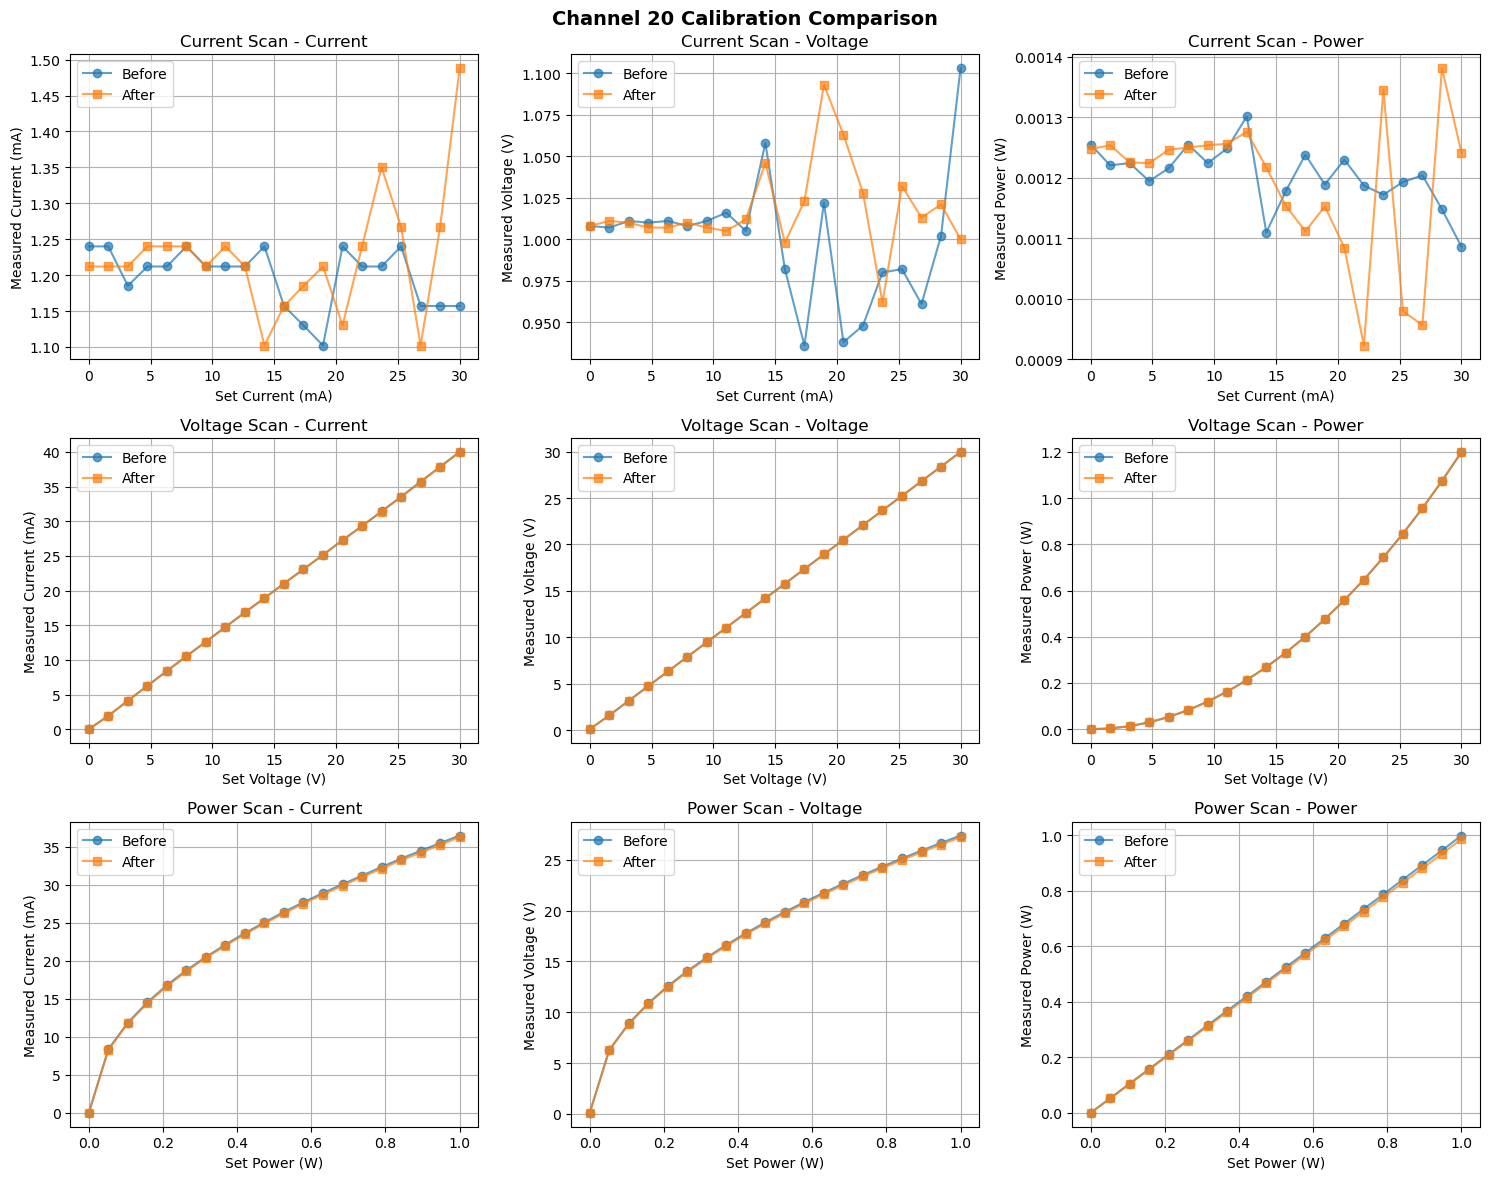

In [8]:
shifter.dac_calibration(plot=True)

---

# Calibrate phase

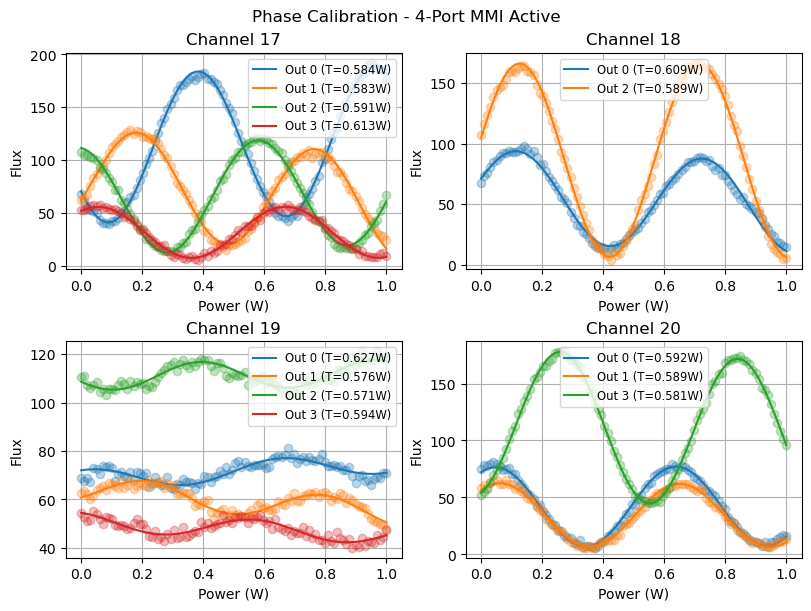

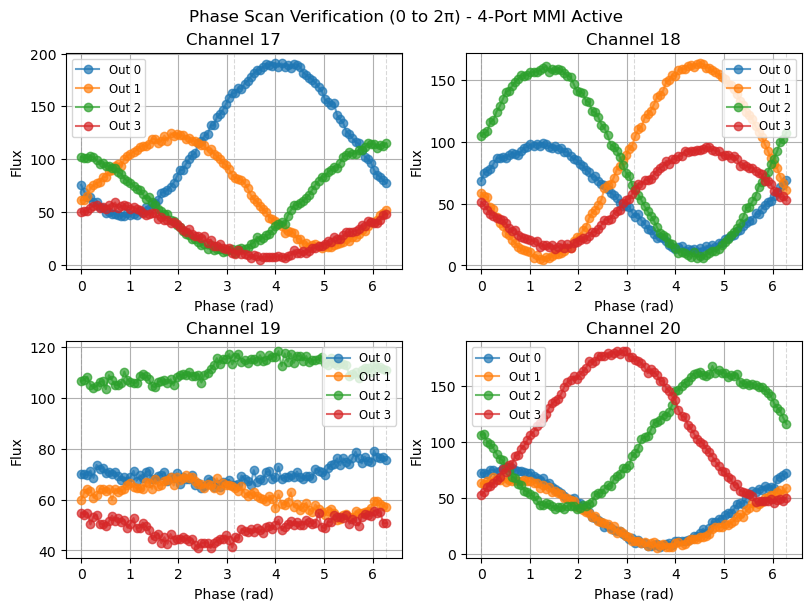

In [11]:
arch.phase_calibration(samples=100, cred3_object=cam, crop_centers=crop_centers, crop_sizes=crop_size, plot=True)

---

# Null calibration

🧬 Starting Genetic Calibration for Arch6...
✅ Genetic calibration complete in 44 iterations.
✅ Genetic calibration complete in 44 iterations.


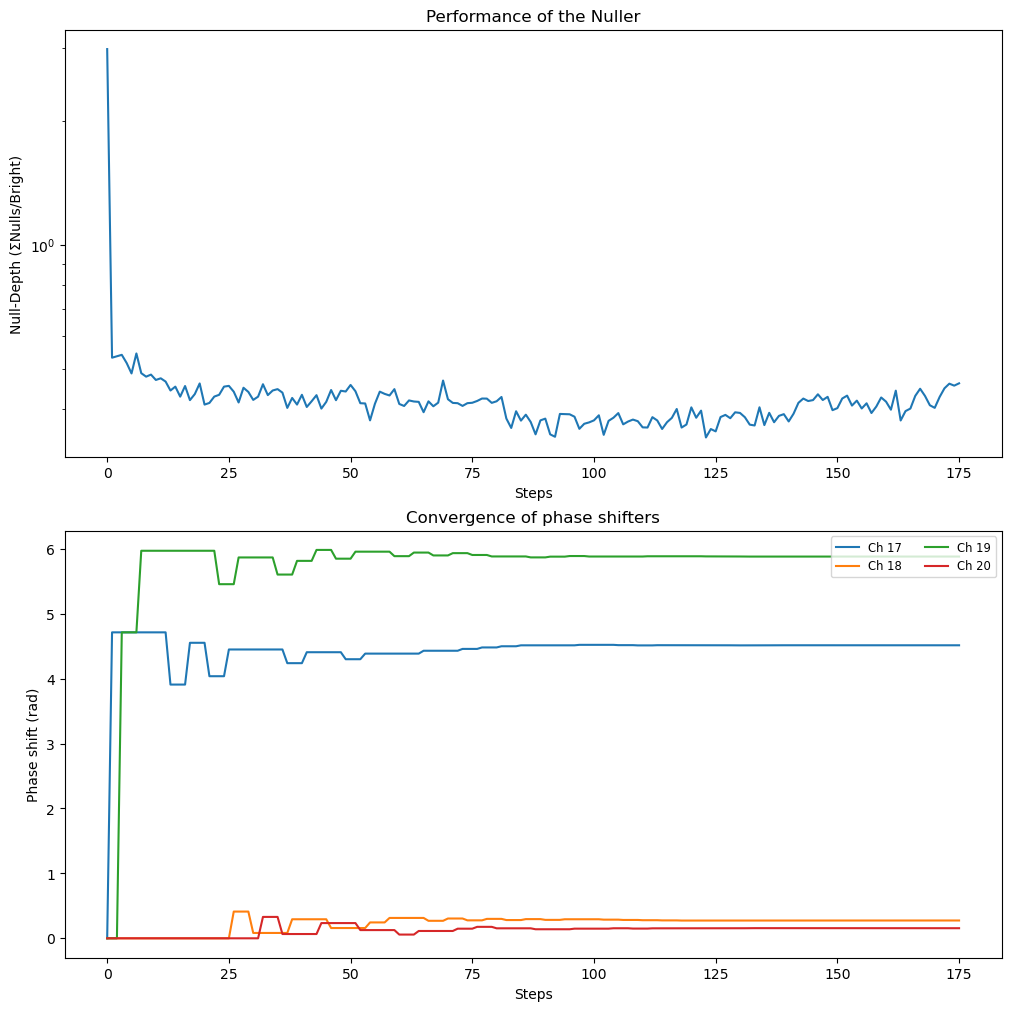

{'depth': array([2.98064895, 0.53214506, 0.53631572, 0.54071739, 0.51660512,
        0.48737658, 0.5448837 , 0.48806304, 0.47871949, 0.48420894,
        0.4699207 , 0.4743364 , 0.46573446, 0.44304952, 0.45277806,
        0.42816769, 0.45432062, 0.41990505, 0.43430771, 0.46087824,
        0.40958037, 0.4133481 , 0.4282616 , 0.43256247, 0.45277451,
        0.45466393, 0.44014354, 0.41443117, 0.44993724, 0.43957346,
        0.42041234, 0.42813625, 0.45886965, 0.43186546, 0.44308354,
        0.44652013, 0.43786261, 0.40206702, 0.42504172, 0.40959203,
        0.4325636 , 0.40416148, 0.417271  , 0.43169638, 0.40050465,
        0.41585474, 0.44429077, 0.41975964, 0.44243983, 0.44063047,
        0.45705416, 0.44120881, 0.41275647, 0.41214736, 0.37501991,
        0.4113859 , 0.44027499, 0.4348193 , 0.43094877, 0.44647139,
        0.41102463, 0.40640059, 0.41919749, 0.41670078, 0.41582589,
        0.39252658, 0.41705304, 0.40575429, 0.41399608, 0.46842158,
        0.42201599, 0.41342374, 0.41278

In [12]:
arch.null_calibration_gen(cred3_object=cam, crop_centers=crop_centers, crop_sizes=crop_size, plot=True)

---

# Scan on one shifter using 1 & 2 inputs

In [ ]:
kbench.xpow.turn_off()
dm.max()

In [ ]:
arch.characterize(dm_object=dm, cred3_object=cam, crop_centers=crop_centers, crop_sizes=10, phase_samples=51, n_averages=10, plot=True, verbose=False)

---

In [ ]:
# # Test the new set_power() method with auto-calibration
# shifter = kbench.PhaseShifter(17)

# power_range = np.linspace(0, 1, 31)

# real_voltage = np.empty_like(power_range)
# real_current = np.empty_like(power_range)
# real_power = np.empty_like(power_range)

# for i, p in enumerate(power_range):
#     shifter.set_power(p)
#     real_voltage[i] = shifter.get_voltage()
#     real_current[i] = shifter.get_current()
#     real_power[i] = shifter.get_power()

# print(real_current, real_voltage, real_power)

# fig, axs = plt.subplots(1, 3, figsize=(12, 4))
# axs[0].plot(power_range, real_voltage, '-o')
# axs[0].set_ylabel("Voltage (V)")
# axs[0].set_xlabel("Set Power (W)")
# axs[0].grid()

# axs[1].plot(power_range, real_current, '-o')
# axs[1].set_ylabel("Current (mA)")
# axs[1].set_xlabel("Set Power (W)")
# axs[1].grid()

# axs[2].plot(power_range, real_power, '-o')
# axs[2].plot(power_range, power_range, '--', label='Ideal')
# axs[2].set_ylabel("Measured Power (W)")
# axs[2].set_xlabel("Set Power (W)")
# axs[2].legend()
# axs[2].grid()
# plt.tight_layout()


In [ ]:
# # Data acquisition
# flux = []
# for power in ramp:
#     shifter.set_power(power)
#     flux.append(cam.get_outputs(crop_centers=crop_centers, crop_sizes=crop_size))


# plt.figure()
# plt.plot(ramp, flux)
# plt.xlabel("Power (W)")
# plt.ylabel("Flux (ADU)")
# plt.title("Flux vs Power")
# plt.grid()

# sleep(3)
# shifter.turn_off()

In [ ]:
arch.phase_calibration(samples=50, cred3_object=cam, crop_centers=crop_centers, crop_sizes=crop_size, plot=True)

In [ ]:
# dm.segments[135].set_ptt(-1150, 0, -5.47)
# dm.segments[136].set_ptt(-1150, 0, -5.47)
# dm.segments[137].set_ptt(-1150, 0, -5.47)
# dm.segments[138].set_ptt(-1150, 0, -5.47)
# dm.segments[135].set_ptt(-1150,0,0)
# dm.segments[136].set_ptt(-1150,0,0)
# dm.segments[137].set_ptt(-1150,0,0)
# dm.segments[138].set_ptt(-1150,0,0)



In [ ]:
# Power ramp
ramp = np.linspace(0, 2*np.pi, 101) # [W]

# Data acquisition
flux = []
for shift in ramp:
    shifter.set_phase(shift)
    temp = []
    for i in range(20):
        temp.append(cam.get_outputs(crop_centers=crop_centers, crop_sizes=crop_size))
    flux.append(np.mean(temp, 0))
flux = np.array(flux)
kbench.xpow.turn_off()

In [ ]:
# Power ramp
ramp = np.linspace(0, 2*np.pi, 101) # [W]

# Data acquisition
flux2 = []
for shift in ramp:
    shifter.set_phase(shift*0)
    temp = []
    for i in range(20):
        temp.append(cam.get_outputs(crop_centers=crop_centers, crop_sizes=crop_size))
    flux2.append(np.mean(temp, 0))
flux2 = np.array(flux2)
kbench.xpow.turn_off()

In [ ]:
# plt.figure()
# plt.plot(ramp, flux, label='With phase shift')
# # plt.plot(ramp, flux2, '--', label='Without phase shift')
# plt.xlabel("Phase (rad)")
# plt.ylabel("Flux (ADU)")
# plt.title("Flux vs Phase")
# plt.grid()
# plt.tight_layout()
# plt.savefig("/media/photonics/SSD 128Go/data/2025-12-04/001/phase_vs_flux.png", dpi=150)

In [ ]:
plt.figure()
plt.plot(ramp, flux-flux.mean(0), label='With phase shift')
plt.plot(ramp, np.sum(flux-flux.mean(0), axis=1), ':', label='With')
plt.plot(ramp, flux2-flux2.mean(0), '--', label='Without phase shift')
plt.xlabel("Phase (rad)")
plt.ylabel("Flux (ADU)")
plt.title("Flux vs Phase")
plt.grid()
plt.tight_layout()
# plt.savefig("/media/photonics/SSD 128Go/data/2025-12-04/001/phase_vs_flux_avg0.png", dpi=150)

In [ ]:
# frame = cam.get_image()
# np.save("/media/photonics/SSD 128Go/data/2025-12-04/001/frame_ttoff.npy", frame)